# <center> Проект Booking

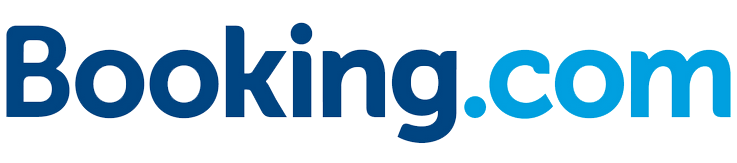

## Постановка задачи

Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

## Загрузка данных

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [2]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

В столбцах lat и lng имеются пропуски. Мы вернемся к ним попозже

## Очистка данных

### Очистка от дупликатов

In [3]:
print('Количество дубликатов: {}'.format(hotels[hotels.duplicated()].shape[0]))

# Удаляем дубликаты:
hotels = hotels.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(hotels.shape))

Количество дубликатов: 336
Размер таблицы после удаления дубликатов: (515402, 18)


In [4]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515402 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515402 non-null  object 
 1   additional_number_of_scoring                515402 non-null  int64  
 2   review_date                                 515402 non-null  object 
 3   average_score                               515402 non-null  float64
 4   hotel_name                                  515402 non-null  object 
 5   reviewer_nationality                        515402 non-null  object 
 6   negative_review                             515402 non-null  object 
 7   review_total_negative_word_counts           515402 non-null  int64  
 8   total_number_of_reviews                     515402 non-null  int64  
 9   positive_review                             515402 non-null  object 
 

## Проектирование признаков

### Преобразование строковых значений

#### Создание новых признаков

##### Признаки времени

In [5]:
# приводим дату отзыва к формату datetime
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

# выделим год и период из даты отзыва
hotels['review_year'] = hotels['review_date'].dt.year
hotels['review_period'] = hotels['review_date'].dt.to_period("M")

In [6]:
# преобразуем признак days_since_review в числовой
hotels['days_since_review'] = hotels['days_since_review'].str.extract('(\d+)').astype(int)

##### Тэги

In [7]:
tags_unique = set()
tags_list = list()

# извлекаем тэги
for index, value in hotels['tags'].items():
        pre_tags = value
        pre_tags = pre_tags.replace('[', '').replace(']', '')
        pre_tags = pre_tags.replace("'", '')
        pre_tags = pre_tags.split(",")
        for i in pre_tags:
            tags_unique.add(i.strip())
            tags_list.append(i.strip())

print("\nЧисло уникальных тэгов:", len(tags_unique))
print("\nОбщее число тэгов:", len(tags_list)) 


Число уникальных тэгов: 2428

Общее число тэгов: 2355078


Закодировать все уникальные тэги не представляется возможным из-за их чрезмерного количества, так что попробуем выжать из них как можно больше полезной информации. 

Посмотрим, какие тэги используются чаще всего:

In [8]:
# считаем частоту всех тэгов
tags_series = pd.Series(
    data = tags_list,
    index = tags_list,
    name = 'tags_series'
)
print("\nТоп 50 самых частых тэгов:", "\n")
print(tags_series.value_counts()[:50]) 


Топ 50 самых частых тэгов: 

Leisure trip                      417513
Submitted from a mobile device    307458
Couple                            252117
Stayed 1 night                    193557
Stayed 2 nights                   133846
Solo traveler                     108468
Stayed 3 nights                    95754
Business trip                      82880
Group                              65357
Family with young children         60986
Stayed 4 nights                    47774
Double Room                        35207
Standard Double Room               32246
Superior Double Room               31359
Family with older children         26331
Deluxe Double Room                 24810
Double or Twin Room                22393
Stayed 5 nights                    20825
Standard Double or Twin Room       17478
Classic Double Room                16865
Superior Double or Twin Room       13570
2 rooms                            12382
Stayed 6 nights                     9762
Standard Twin Room         

Можем вынести информацию о типе номера, продолжительности проживания в отеле, типе гостей и так далее

In [9]:
# функция определения типа номера
def room_type(tags):
    premiers = ["Premier", "Royal", "President", "Presidential", 
                "Ordinary",  "Adjacent", "Exception"  ]
    luxuries = ['Luxury',  "Panoramic", 'Classic', "Loft", "Montcalm", "Privilege", 
                "Special", "Camper", "Sensation", "Classique", "Privilege", "Wonderful"]
    deluxes  = ['Deluxe', "Premium"] 
    larges   = ['Quadruple', 'Triple', 'Duplex', "Penthouse", "Townhouse",
                "Connecting", "Apartment", "Apartments"]
    queens   = ['Queen', 'King']
    comforts = ['Comfort','Large', 'Cosy',  'Cozy', 'Extra', 'Plus', 
                "Club", 'Art', 'View', 'Studio', "City", "Emotion"]

    for premier in premiers:
        if premier in tags:
            return 'premier'
    for luxury in luxuries:
        if luxury in tags:
            return 'luxury'
    if 'Suite' in tags:
        return 'suite'
    for deluxe in deluxes:
        if deluxe in tags:
            return 'deluxe'
    if "Executive" in tags:
        return 'executive'
    if "Superior" in tags:
        return 'superior'
    for large in larges:
        if large in tags:
            return 'large'
    for queen in queens:
        if queen in tags:
            return 'queen'
    if "Guest" in tags:
        return 'guest'
    if "Family" in tags:
        return 'family'
    if "Business" in tags:
        return 'business'
    for comfort in comforts:
        if comfort in tags:
            return 'comfort'
    if 'Double' in tags:
            return 'double'
    else:
        return 'standard'

# создаем новый столбец типа номера
hotels["type_of_room"] = hotels["tags"].apply(room_type)

hotels['type_of_room'].value_counts()

double       102579
superior      84375
deluxe        66996
luxury        42372
business      40389
family        38430
queen         32113
standard      31035
comfort       19994
executive     18280
suite         16409
large         11244
guest          8609
premier        2577
Name: type_of_room, dtype: int64

In [10]:
import re
import numpy as np

# функция определения продолжительности пребывания в отеле
def number_of_nights(tags):
    express = re.findall(r'Stayed\s([0-9]+)\snight', tags)
    for elem, num in enumerate(express):
        return np.int8(num)
    
hotels['number_of_nights'] = hotels['tags'].apply(number_of_nights)


# заполним пропуски
mode_nights = hotels['number_of_nights'].mode()[0]
hotels['number_of_nights'] = hotels['number_of_nights'].fillna(mode_nights)

hotels['number_of_nights'].head()

0    2.0
1    1.0
2    1.0
3    1.0
4    2.0
Name: number_of_nights, dtype: float64

In [11]:
# функция определения типа гостя
def guest_type(tags):
    express = re.findall(r'Couple|Group|Family|Solo', tags)
    for elem, word in enumerate(express):
        return word

hotels['type_of_guests'] = hotels['tags'].apply(guest_type)

# заполним пропуски
mode_guest = hotels['type_of_guests'].mode()[0]
hotels['type_of_guests'] = hotels['type_of_guests'].fillna(mode_guest)

hotels['type_of_guests'].value_counts()

Couple    254228
Solo      108468
Family     87349
Group      65357
Name: type_of_guests, dtype: int64

##### Название отеля

Подробнее исследуем признак названия отеля

In [12]:
# исследуем на наличие дупликатов
pivot = hotels[['hotel_address', 'hotel_name']].groupby(
    by='hotel_name'
).nunique()

name_rep = pivot[pivot['hotel_address'] != 1].index.to_list()
mask = hotels['hotel_name'].isin(name_rep)
addresses_rep = hotels[mask][['hotel_name', 'hotel_address']].value_counts()

display(addresses_rep)

# чтобы различать эти отели при анализе добавим в название город
hotels['hotel_name'] = hotels.apply(
    lambda x: (x['hotel_name'] + ' ' + x['hotel_address'].split()[-2])
    if (x['hotel_name'] in name_rep)
    else x['hotel_name'], axis=1)


hotel_name    hotel_address                                             
Hotel Regina  Bergara 2 4 Eixample 08002 Barcelona Spain                    590
              Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria           284
              Via Cesare Correnti 13 Milan City Center 20123 Milan Italy     60
dtype: int64

In [13]:
# смотрим, сколько у нас уникальных значений названий отеля
display(hotels['hotel_name'].nunique())

1494

##### Расположение отеля

Для начала, давайте разберемся с адресом:

In [14]:
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: x.split()[-1]\
                                            if x.split()[-1] != 'Kingdom'\
                                                    else ' '.join(x.split()[-2:]))

print('\nВ датасете представлены отели из '+str(hotels['hotel_country'].nunique())+' различных стран.\n')
print(hotels['hotel_country'].value_counts())

hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x: x.split()[-2]\
                                         if x.split()[-1] != 'Kingdom'\
                                         else x.split()[-5])

print('\nВ датасете представлены отели из '+str(hotels['hotel_city'].nunique())+' различных городов.\n')
print(hotels['hotel_city'].value_counts())


В датасете представлены отели из 6 различных стран.

United Kingdom    262299
Spain              60149
France             59598
Netherlands        57212
Austria            38938
Italy              37206
Name: hotel_country, dtype: int64

В датасете представлены отели из 6 различных городов.

London       262299
Barcelona     60149
Paris         59598
Amsterdam     57212
Vienna        38938
Milan         37206
Name: hotel_city, dtype: int64


Теперь пришло время заполнить пропуски в координатах! Поскольку отелей с пропусками в координатах всего 17, я решила особо не запариваться и заполнить их вручную:)

In [15]:
# создаем отдельный датасет с отелями без координат
hotels_no_coor = hotels[hotels.lng.isna() & hotels.lat.isna()].groupby(by = ['hotel_address','hotel_name']).count().iloc[:,0].to_frame().reset_index()
hotels_no_coor.head()

,hotel_address,hotel_name,additional_number_of_scoring
0,20 Rue De La Ga t 14th arr 75014 Paris France,Mercure Paris Gare Montparnasse,37
1,23 Rue Damr mont 18th arr 75018 Paris France,Holiday Inn Paris Montmartre,55
2,4 rue de la P pini re 8th arr 75008 Paris France,Maison Albar Hotel Paris Op ra Diamond,290
3,Bail n 4 6 Eixample 08010 Barcelona Spain,NH Collection Barcelona Podium,146
4,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,City Hotel Deutschmeister,93


In [16]:
# пропущенные координаты
hotels_no_coor[['lat','lng']] = 0
hotels_no_coor.loc[0,['lat','lng']] = ['48.8399957','2.3070823']
hotels_no_coor.loc[1,['lat','lng']] = ['48.8889127','2.3309643']
hotels_no_coor.loc[2,['lat','lng']] = ['48.8753208','2.3212033']
hotels_no_coor.loc[3,['lat','lng']] = ['41.391552','2.1757053']
hotels_no_coor.loc[4,['lat','lng']] = ['48.2208555','16.3644228']
hotels_no_coor.loc[5,['lat','lng']] = ['48.233592','16.3434781']
hotels_no_coor.loc[6,['lat','lng']] = ['48.2094054','16.3512565']
hotels_no_coor.loc[7,['lat','lng']] = ['48.2095525','16.3492746']
hotels_no_coor.loc[8,['lat','lng']] = ['48.1888183','16.381591']
hotels_no_coor.loc[9,['lat','lng']] = ['48.1868142','16.418528']
hotels_no_coor.loc[10,['lat','lng']] = ['41.3749946','2.1102353']
hotels_no_coor.loc[11,['lat','lng']] = ['48.219573','16.2834034']
hotels_no_coor.loc[12,['lat','lng']] = ['41.3832425','2.1607609']
hotels_no_coor.loc[13,['lat','lng']] = ['48.2458909','16.3397395']
hotels_no_coor.loc[14,['lat','lng']] = ['48.2135906','16.3777195']
hotels_no_coor.loc[15,['lat','lng']] = ['48.2168032','16.357717']
hotels_no_coor.loc[16,['lat','lng']] = ['48.220414','16.3536299']

hotels_no_coor.set_index('hotel_address', inplace=True)

# создаем функцию для добавления пропущенных координат
def add_missing_coors(address, data_dict):
    if address in data_dict.index:
        return pd.Series([data_dict.loc[address].lat, data_dict.loc[address].lng],
                     index = ['lat','lng'])

# заполняем пропуски
hotels.loc[hotels[(hotels.lat.isna() | hotels.lng.isna())].index,['lat','lng']] = \
hotels[hotels.lat.isna() | hotels.lng.isna()].loc[:].apply(lambda x: add_missing_coors(x.hotel_address, hotels_no_coor), axis = 1)

# проверим, что пропусков у нас нет
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515402 entries, 0 to 515737
Data columns (total 25 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515402 non-null  object        
 1   additional_number_of_scoring                515402 non-null  int64         
 2   review_date                                 515402 non-null  datetime64[ns]
 3   average_score                               515402 non-null  float64       
 4   hotel_name                                  515402 non-null  object        
 5   reviewer_nationality                        515402 non-null  object        
 6   negative_review                             515402 non-null  object        
 7   review_total_negative_word_counts           515402 non-null  int64         
 8   total_number_of_reviews                     515402 non-null  int64        

Мы избавились от пропусков! Отлично!

Зачастую, довольно важным аспектом при выборе отеля является его близость к центру города. И как правило, фактор расположения отеля в пешей доступности от центра города  сильно влияет на его оценку.

Давайте вычислим расстояние от отеля до центра города!

In [17]:
# создаем словарь с координатами (lat, lng) центра для каждого города
cities_dict = {
    'Paris'    : [48.8534100, 2.3488000],
    'London'   : [51.5085300, -0.1257400],
    'Barcelona': [41.3887900, 2.1589900],
    'Milan'    : [45.4642700, 9.1895100],
    'Vienna'   : [48.2084900, 16.3720800],
    'Amsterdam': [52.3740300, 4.8896900],
}

import geopy.distance
from geopy import distance

def distance_to_centre(city, lat, lng):
    return geopy.distance.geodesic([cities_dict[city][0], 
                                    cities_dict[city][1]],
                                   [lat, lng]).km

hotels['distance_from_centre'] = hotels.apply(lambda x:
                                  distance_to_centre(x['hotel_city'], x['lat'], x['lng']), 
                                  axis = 1)

hotels['distance_from_centre'].head()

0    7.788060
1    3.978037
2    0.532699
3    1.815149
4    0.394315
Name: distance_from_centre, dtype: float64

С расположением разобрались!

##### Национальность ревьюера

In [18]:
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x.strip())

print('В датасете присутствуют {} различных национальностей рецензентов.\n'.format(hotels['reviewer_nationality'].nunique()))
hotels['reviewer_nationality'].value_counts(normalize=True).head(15)

В датасете присутствуют 227 различных национальностей рецензентов.



United Kingdom              0.475664
United States of America    0.068655
Australia                   0.042029
Ireland                     0.028752
United Arab Emirates        0.019849
Saudi Arabia                0.017355
Netherlands                 0.017000
Switzerland                 0.016826
Germany                     0.015394
Canada                      0.015301
France                      0.014115
Israel                      0.012811
Italy                       0.011861
Belgium                     0.011692
Turkey                      0.010557
Name: reviewer_nationality, dtype: float64

Давайте добавим признак принадлежности рецензента к стране, где располагается отель.

In [19]:
hotels['local_reviewer'] = hotels.apply(lambda x: 1 if x['reviewer_nationality'] == x['hotel_country'] else 0, axis=1)

hotels['local_reviewer'].value_counts(normalize=True)

0    0.653899
1    0.346101
Name: local_reviewer, dtype: float64

Мы видим, что около двух третей рецензентов являются иностранцами, а остальная часть приходится на местных. Предлагаю также сократить кол-во национальностей до 10 самых частых.

In [20]:
# создаем список 10 самых частых значений национальности рецензентов
most_frequent_nationalities = hotels['reviewer_nationality'].value_counts()[:10]

hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x if x in most_frequent_nationalities else 'Other')
print(hotels['reviewer_nationality'].value_counts(normalize=True))

United Kingdom              0.475664
Other                       0.283175
United States of America    0.068655
Australia                   0.042029
Ireland                     0.028752
United Arab Emirates        0.019849
Saudi Arabia                0.017355
Netherlands                 0.017000
Switzerland                 0.016826
Germany                     0.015394
Canada                      0.015301
Name: reviewer_nationality, dtype: float64


In [21]:
data_agg = hotels.groupby('reviewer_nationality')['reviewer_score'].describe().round(2)
print('Распределение оценок в зависимости от страны рецензента\n')
data_agg

Распределение оценок в зависимости от страны рецензента



,count,mean,std,min,25%,50%,75%,max
reviewer_nationality,,,,,,,,
Australia,21662.0,6.43,3.94,0.0,0.0,8.3,9.6,10.0
Canada,7886.0,6.51,3.90,0.0,3.8,8.3,9.6,10.0
Germany,7934.0,6.09,3.80,0.0,2.5,7.5,9.2,10.0
Ireland,14819.0,6.35,3.90,0.0,2.5,7.9,9.6,10.0
Netherlands,8762.0,6.13,3.78,0.0,2.9,7.9,9.2,10.0
Other,145949.0,6.16,3.84,0.0,0.0,7.9,9.2,10.0
Saudi Arabia,8945.0,5.92,3.78,0.0,2.5,7.5,9.2,10.0
Switzerland,8672.0,6.11,3.80,0.0,0.0,7.5,9.2,10.0
United Arab Emirates,10230.0,5.87,3.81,0.0,0.0,7.5,9.2,10.0


##### Отзывы

Давайте перейдем к отзывам!

In [22]:
# приведем отзывы в удобный для работы вид
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.strip().lower())
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: x.strip().lower())
hotels['negative_review'] = hotels['negative_review'].apply(
                            lambda x: x.replace('no negative', ''))
hotels['positive_review'] = hotels['positive_review'].apply(
                            lambda x: x.replace('no positive', ''))
hotels['negative_review'] = hotels['negative_review'].apply(
                            lambda x: x.replace('nothing', ''))
hotels['positive_review'] = hotels['positive_review'].apply(
                            lambda x: x.replace('nothing', ''))

#### Кодирование признаков

##### One Hot Coding

In [23]:
columns_ohc = ['reviewer_nationality', 'type_of_room', 'type_of_guests', 'hotel_city']

import category_encoders as ce # импорт для работы с кодировщиком

encoder = ce.OneHotEncoder(cols=columns_ohc, use_cat_names=True) # указываем столбец для кодирования
hotels_ohc = encoder.fit_transform(hotels[columns_ohc])
hotels = pd.concat([hotels, hotels_ohc], axis=1)

hotels = hotels.drop(columns_ohc, axis=1)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515402 entries, 0 to 515737
Data columns (total 58 columns):
 #   Column                                         Non-Null Count   Dtype         
---  ------                                         --------------   -----         
 0   hotel_address                                  515402 non-null  object        
 1   additional_number_of_scoring                   515402 non-null  int64         
 2   review_date                                    515402 non-null  datetime64[ns]
 3   average_score                                  515402 non-null  float64       
 4   hotel_name                                     515402 non-null  object        
 5   negative_review                                515402 non-null  object        
 6   review_total_negative_word_counts              515402 non-null  int64         
 7   total_number_of_reviews                        515402 non-null  int64         
 8   positive_review                             

In [24]:
drop_cols = [i for i in hotels.columns if hotels[i].dtypes == 'object' or hotels[i].dtypes == 'datetime64[ns]' or hotels[i].dtype.name == 'period[M]']
hotels.drop(drop_cols, axis = 1, inplace=True)

#### Преобразование (нормализация) признаков

Для нормализации будем использовать RobustScaler

In [25]:
# Разделение на train и test-данные
#train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
#test_data = hotels.query('sample == 0').drop(['sample'], axis=1)
#X = train_data.drop(['reviewer_score'], axis=1)
#y = train_data['reviewer_score'].values
 
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_SEED, test_size = 0.20)

# Нормализация данных
#scaler = preprocessing.RobustScaler()
#scaler.fit(X_train)

#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

In [39]:
# Теперь выделим тестовую часть
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [40]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)


In [41]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128906, 47), (386496, 47), (386496, 46), (309196, 46), (77300, 46))

In [27]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [28]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [42]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


In [44]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_pred, y_test))

MAPE: 0.9348660149079032


<AxesSubplot:>

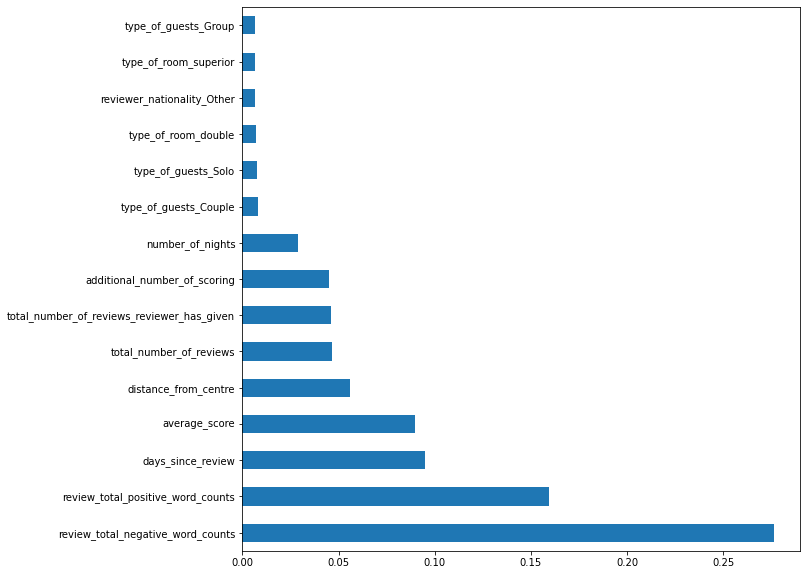

In [31]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [32]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,review_year,number_of_nights,...,type_of_guests_Couple,type_of_guests_Group,type_of_guests_Solo,type_of_guests_Family,hotel_city_Milan,hotel_city_Amsterdam,hotel_city_Barcelona,hotel_city_London,hotel_city_Paris,hotel_city_Vienna
14592,299,8.3,60,1361,32,1,1,0.0,2017,2.0,...,0,0,1,0,0,0,0,1,0,0
107026,545,8.0,0,2907,11,10,400,0.0,2016,3.0,...,0,0,1,0,0,0,0,1,0,0
22248,1243,8.1,6,6608,5,1,654,0.0,2015,1.0,...,1,0,0,0,0,0,0,1,0,0
75611,639,9.2,12,2619,25,1,284,0.0,2016,1.0,...,1,0,0,0,0,0,0,1,0,0
66782,947,8.7,0,8177,72,20,521,0.0,2016,2.0,...,0,0,0,1,0,1,0,0,0,0
2167,2288,8.1,0,9568,12,1,210,0.0,2017,1.0,...,1,0,0,0,0,0,0,1,0,0
39259,1258,9.4,0,4204,8,4,120,0.0,2017,2.0,...,0,0,1,0,0,0,0,1,0,0
111846,293,9.1,0,1650,4,1,150,0.0,2017,3.0,...,0,1,0,0,0,1,0,0,0,0
51101,230,8.2,12,2836,37,14,75,0.0,2017,2.0,...,1,0,0,0,0,0,1,0,0,0
104717,172,8.3,41,1601,0,10,271,0.0,2016,3.0,...,0,0,1,0,0,0,1,0,0,0


In [33]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [34]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [35]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.0s finished


In [36]:
predict_submission

array([9.055, 6.874, 8.218, ..., 8.085, 9.369, 7.449])

In [37]:
list(sample_submission)

['reviewer_score', 'id']

In [38]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

ValueError: Length of values (128906) does not match length of index (128935)